In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
import multiprocessing as mp

In [2]:
import sys
module_path = '/Users/junhaoxiong 1/Documents/Projects/mgcpy'
if module_path not in sys.path:
    sys.path.append(module_path)
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.benchmarks.power import power
from mgcpy.benchmarks.simulations import *
from mgcpy.independence_tests.mgc.mgc import MGC
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.hhg import HHG
from mgcpy.independence_tests.kendall_spearman import KendallSpearman

In [3]:
def compute_distance_matrix(data_matrix_X, data_matrix_Y):
    # obtain the pairwise distance matrix for X and Y
    dist_mtx_X = squareform(pdist(data_matrix_X, metric='euclidean'))
    dist_mtx_Y = squareform(pdist(data_matrix_Y, metric='euclidean'))
    return (dist_mtx_X, dist_mtx_Y)

## Power vs. Dimension

In [4]:
def power_vs_dimension(independence_test, simulation_type, dim_range, sim_name):
    '''
    Generate power of an independence test given a simulation for a range of dimensions
    
    :param independence_test: an independence_test object
    :param simulation_type: a simulation function from mgcpy.benchmarks.simulations
    :param dim_range: the upper end of the range of dimension
    :return: power for each dimension
    '''
    estimated_power = np.zeros(dim_range)
    for d in range(1, dim_range+1):
        estimated_power[d-1] = power(independence_test, simulation_type, num_samples=100, num_dimensions=d, 
                                     simulation_type=sim_name)
    return estimated_power

In [5]:
def compute_all_power_vs_dimension(simulation_type, dim_range, sim_name):
    '''
    Compute power for each independence test for each dimension in a specified range 
    '''

    '''
    Initialize all independence test objects
    Data matrices initialized to np.nan, because in power computation each repeats involves generating new samples
    '''
    mcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='mcorr')
    dcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='dcorr')
    mantel = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='mantel')
    mgc = MGC(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix)
    rv_corr = RVCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix)
    hhg = HHG(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix)
    cca = RVCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix, which_test='cca')
    
    
    independence_tests = {'MGC': mgc, 'MCorr': mcorr, 'DCorr': dcorr, 'Mantel': mantel,
                          'RV Corr': rv_corr, 'CCA': cca} #, 'HHG': hhg}
    power_results = {}
    
    
    # compute power for each test for each dimension
    for name, test in independence_tests.items():
        power = power_vs_dimension(test, simulation_type, dim_range, sim_name)
        power_results[name] = power
        print('{} finished'.format(name))
    
    #independence_tests = [mcorr, dcorr]
    #power_results = Parallel(n_jobs=2)(iter[delayed(power_vs_dimension)(test, simulation_type, dim_range) for test in independence_tests])
    
    
    return power_results

In [6]:
def find_dim_range(sim_name):
    dim_range = 0
    if sim_name in ['joint_normal', 'sine_4pi', 'sine_16pi', 'multi_noise']:
        dim_range = 10
    elif sim_name in ['step', 'spiral', 'circle', 'ellipse', 'quadratic', 'w_shape', 'two_parabolas', 'fourth_root']:
        dim_range = 20
    elif sim_name in ['multi_indept', 'bernoulli', 'log']:
        dim_range = 100
    else:
        dim_range = 40
    return dim_range

In [46]:
'''
simulations = {'joint_normal': joint_sim, 'sine_4pi': sin_sim, 'sine_16pi': sin_sim, 'multi_noise': multi_noise_sim,
               'step': step_sim, 'spiral': spiral_sim, 'circle': circle_sim, 'ellipse': circle_sim, 'diamond': square_sim,
               'log': log_sim, 'quadratic': quad_sim, 'w_shape': w_sim, 'two_parabolas': two_parab_sim, 'fourth_root': root_sim',
               multi_indept': multi_indep_sim, 'bernoulli': ubern_sim}
'''
simulations = {'bernoulli': ubern_sim}


for sim_name, sim_func in simulations.items():
    power_results = compute_all_power_vs_dimension(sim_func, find_dim_range(sim_name), sim_name)
    pickle.dump(power_results, open('../../NeuroData/power_curve_{}.pkl'.format(sim_name), 'wb'))
    print('{} finished'.format(sim_name))

MGC finished
MCorr finished
DCorr finished
Mantel finished
RV Corr finished
CCA finished
bernoulli finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_bernoulli.pkl'>
  if sys.path[0] == '':


## Power vs. Sample Size

In [9]:
def power_vs_sample_size(independence_test, simulation_type, sim_name):
    '''
    Generate power of an independence test given a simulation for a range of sample size
    range is [5, 10, 15, ..., 95, 100]
    
    :param independence_test: an independence_test object
    :param simulation_type: a simulation function from mgcpy.benchmarks.simulations
    :return: power for each sample size
    '''
    sample_sizes = [i for i in range(5, 101, 5)]
    estimated_power = np.zeros(len(sample_sizes))
    
    for i, size in enumerate(sample_sizes):
        estimated_power[i] = power(independence_test, simulation_type, num_samples=size, num_dimensions=1, noise=1,
                                     simulation_type=sim_name)
    return estimated_power

In [23]:
def compute_all_power_vs_sample_size(simulation_type, sim_name):
    '''
    Compute power for each independence test for each dimension in a specified range 
    '''

    '''
    Initialize all independence test objects
    Data matrices initialized to np.nan, because in power computation each repeats involves generating new samples
    '''
    mcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='mcorr')
    dcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='dcorr')
    mantel = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='mantel')
    mgc = MGC(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix)
    hhg = HHG(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix)
    pearson = RVCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix, which_test='pearson')
    
    
    independence_tests = {'Pearson': pearson} #{'MGC': mgc, 'MCorr': mcorr, 'DCorr': dcorr, 'Mantel': mantel,
                          #'Pearson': pearson} #, 'HHG': hhg}
    power_results = {}
    
    
    # compute power for each test for each dimension
    for name, test in independence_tests.items():
        power = power_vs_sample_size(test, simulation_type, sim_name)
        power_results[name] = power
        print('{} finished'.format(name))
    
    return power_results

In [24]:
#simulations = {'bernoulli': ubern_sim, , 'square': square_sim, 'linear': linear_sim, 'exponential': exp_sim,'cubic': cub_sim}

simulations = {'joint_normal':joint_sim, 'sine_4pi': sin_sim, 'sine_16pi': sin_sim, 'multi_noise': multi_noise_sim,
               'step': step_sim, 'spiral': spiral_sim, 'circle': circle_sim, 'ellipse': circle_sim, 'diamond': square_sim,
               'log': log_sim, 'quadratic': quad_sim, 'w_shape': w_sim, 'two_parabolas': two_parab_sim, 'fourth_root': root_sim,
               'multi_indept': multi_indep_sim}

for sim_name, sim_func in simulations.items():
    power_results = compute_all_power_vs_sample_size(sim_func, sim_name)
    file = open('../../NeuroData/power_curve_sample_size_{}.pkl'.format(sim_name), 'wb')
    pickle.dump(power_results, file)
    file.close()
    print('{} finished'.format(sim_name))

Pearson finished
joint_normal finished
Pearson finished
sine_4pi finished
Pearson finished
sine_16pi finished
Pearson finished
multi_noise finished


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in true_divide
  r = r_num / r_den
/Users/junhaoxiong 1/Documents/Projects/mgcpy/mgcpy/benchmarks/power.py:74: RuntimeWarning: invalid value encountered in greater_equal
  empirical_power = np.where(test_stats_alternative >= cutoff)[0].shape[0] / repeats


Pearson finished
step finished
Pearson finished
spiral finished
Pearson finished
circle finished
Pearson finished
ellipse finished
Pearson finished
diamond finished
Pearson finished
log finished
Pearson finished
quadratic finished
Pearson finished
w_shape finished
Pearson finished
two_parabolas finished
Pearson finished
fourth_root finished
Pearson finished
multi_indept finished


Error
* bernoulli: float not subscriptable
    * ~/Documents/Projects/mgcpy/mgcpy/independence_tests/rv_corr.py in test_statistic(self, data_matrix_X, data_matrix_Y)
     81         if (self.which_test == 'pearson') and ((row_X == 1 or columns_X == 1) and (row_Y == 1 or columns_Y == 1)):
     82             corr, covar = pearsonr(data_matrix_X, data_matrix_Y)
---> 83             corr, covar = corr[0], covar[0]
* step / multi_noise: power.py:68: RuntimeWarning: invalid value encountered in greater_equal
  empirical_power = np.where(test_stats_alternative >= cutoff)[0].shape[0] / repeats

In [52]:
power_results = pickle.load(open('../../NeuroData/power_curve_bernoulli.pkl', 'rb'))
#pickle.dump(power_results, open('../../NeuroData/power_curve_spiral.pkl', 'wb'))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='../../NeuroData/power_curve_bernoulli.pkl'>
  """Entry point for launching an IPython kernel.


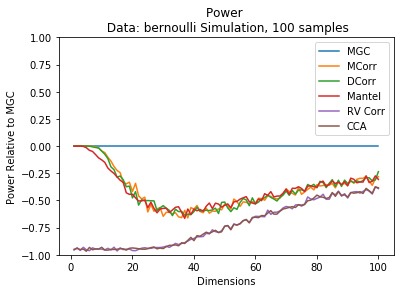

In [55]:
plot_power_curve_dimension(power_results, 'bernoulli')

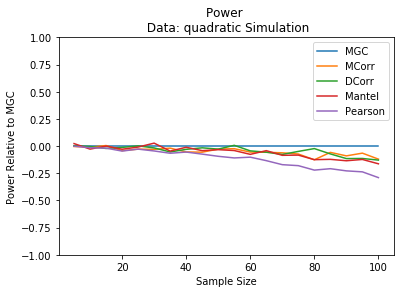

In [51]:
plot_power_curve_sample_size(power_results, 'quadratic')

## Plotting

In [54]:
def plot_power_curve_dimension(power_results, simulation_name):
    '''
    Plot the power of each independence test relative to mgc
    '''
    mgc_power = power_results['MGC']
    dimensions = np.arange(1, mgc_power.shape[0]+1)
    fig,ax = plt.subplots()

    for name, power in power_results.items():     
        ax.plot(dimensions, power-mgc_power, label=name)
    
    #ax.set_xticklabels([20])
    plt.xlabel('Dimensions')
    plt.ylabel('Power Relative to MGC')
    plt.legend()
    plt.gca().set_ylim(-1, 1)
    #plt.xticks(np.arange(1, mgc_power.shape[0]+1))
    plt.title('Power \n Data: {} Simulation, 100 samples'.format(simulation_name))
    #plt.show()

In [13]:
def plot_power_curve_sample_size(power_results, simulation_name):
    '''
    Plot the power of each independence test relative to mgc
    '''
    mgc_power = power_results['MGC']
    sample_sizes = [i for i in range(5, 101, 5)]
    fig,ax = plt.subplots()

    for name, power in power_results.items():     
        ax.plot(sample_sizes, power-mgc_power, label=name)
    
    #ax.set_xticklabels([20])
    plt.xlabel('Sample Size')
    plt.ylabel('Power Relative to MGC')
    plt.legend()
    plt.gca().set_ylim(-1, 1)
    #plt.xticks(np.arange(1, mgc_power.shape[0]+1))
    plt.title('Power \n Data: {} Simulation'.format(simulation_name))
    #plt.show()

In [25]:
def plot_all_curves(which_type):
    simulation_names = ['linear', 'exponential', 'cubic','joint_normal', 'step', 'quadratic', 'w_shape', 'spiral', 
                        'bernoulli', 'log', 'fourth_root', 'sine_4pi',
                       'sine_16pi', 'square', 'two_parabolas', 'circle', 'ellipse', 'diamond', 'multi_noise',
                        'multi_indept']
    
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(14,12))  
    index = 0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            sim_name = simulation_names[index]
            index += 1
            if which_type == 'dimension':
                if i == 0 and (j == 0 or j == 1 or j == 2):
                    col.set_ylim(-1, 1)
                    col.set_yticks([])
                    col.set_title(sim_name)
                    continue
                file = open('../../NeuroData/power_curve_{}.pkl'.format(sim_name),  'rb')
            else:
                file = open('../../NeuroData/power_curve_sample_size_{}.pkl'.format(sim_name),  'rb')

            power_results = pickle.load(file)
            file.close()
            mgc_power = power_results['MGC']
            if which_type == 'dimension':
                x_axis = np.arange(1, mgc_power.shape[0]+1)
            else:
                x_axis = [i for i in range(5, 101, 5)]

            for name, power in power_results.items():
                col.plot(x_axis, power-mgc_power, label=name)
                col.set_ylim(-1, 1)
                col.set_yticks([])
                col.set_title(sim_name)
    plt.legend()
    plt.subplots_adjust(hspace=.75)
    if which_type == 'dimension':
        fig.suptitle('Power Relative to MGC of Increasing Dimensions')
        plt.savefig('../../../../Desktop/Neuro Data Design/all_curves_dimensions')
    else:
        fig.suptitle('Power Relative to MGC of for 20 Simulated 1-Dimensional Settings')
        plt.savefig('../../../../Desktop/Neuro Data Design/all_curves_sample_size')

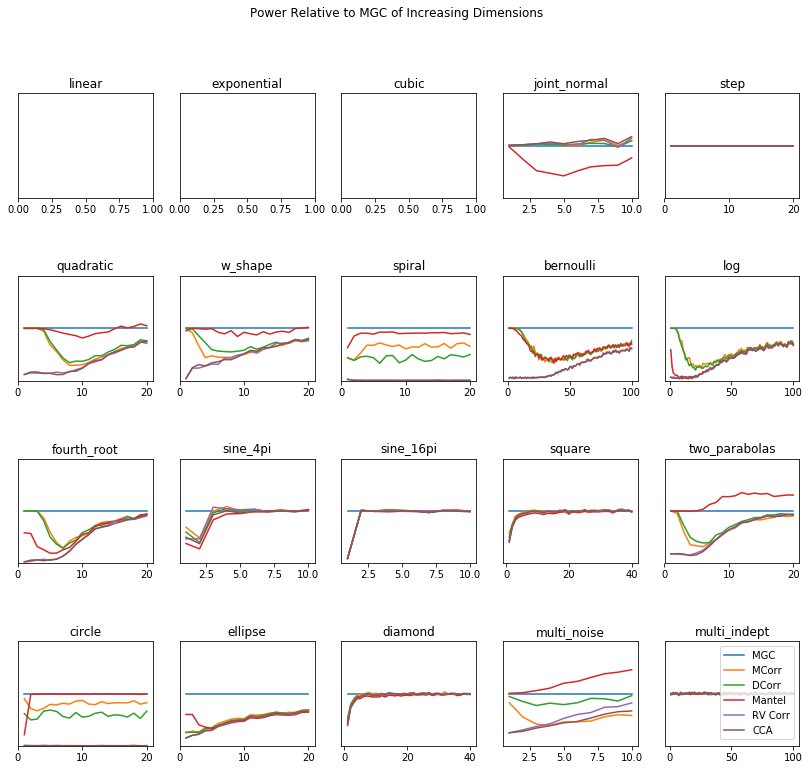

In [27]:
plot_all_curves('dimension')

## Parallel code

In [11]:
def power_vs_dimension_parallel(params_dict):
    '''
    Generate power of an independence test given a simulation for a range of dimensions
    
    :param independence_test: an independence_test object
    :param simulation_type: a simulation function from mgcpy.benchmarks.simulations
    :param dim_range: the upper end of the range of dimension
    :return: power for each dimension
    '''
    print(params_dict['sim_name'], params_dict['independence_test'].get_name())
    estimated_power = np.zeros(params_dict['dim_range'])
    for d in range(1, params_dict['dim_range']+1):
        estimated_power[d-1] = power(params_dict['independence_test'], params_dict['simulation_type'], 
                                     num_samples=100, num_dimensions=d, 
                                     simulation_type=params_dict['sim_name'])
    print('finish')
    return (params_dict, estimated_power)

In [12]:
mcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='mcorr')
dcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='dcorr')

params_dict = [{'independence_test': mcorr, 'simulation_type': quad_sim, 'dim_range': 20, 'sim_name': 'quadratic'}, 
              {'independence_test': dcorr, 'simulation_type': quad_sim, 'dim_range': 20, 'sim_name': 'quadratic'}]

In [13]:
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

quadratic dcorr
quadratic mcorr
finish
finish


In [14]:
results

[({'dim_range': 20,
   'independence_test': <mgcpy.independence_tests.dcorr.DCorr at 0x1a15a836d8>,
   'sim_name': 'quadratic',
   'simulation_type': <function mgcpy.benchmarks.simulations.quad_sim>},
  array([1.   , 1.   , 1.   , 0.924, 0.682, 0.542, 0.353, 0.311, 0.233,
         0.21 , 0.19 , 0.13 , 0.152, 0.164, 0.128, 0.122, 0.104, 0.09 ,
         0.095, 0.093])),
 ({'dim_range': 20,
   'independence_test': <mgcpy.independence_tests.dcorr.DCorr at 0x1a15a835f8>,
   'sim_name': 'quadratic',
   'simulation_type': <function mgcpy.benchmarks.simulations.quad_sim>},
  array([1.   , 1.   , 1.   , 0.972, 0.8  , 0.633, 0.474, 0.392, 0.292,
         0.257, 0.226, 0.165, 0.193, 0.176, 0.161, 0.137, 0.14 , 0.115,
         0.126, 0.124]))]